<a href="https://colab.research.google.com/github/manishbayesian/bayesianbookpub/blob/main/Chapter1_BayesCalculator%2C_Examples_X_XX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Chapter 1: Bayes Theorem & Examples X-XX. 
A simple calculator usingn Bayes' Theorem, and its applications as in Examples X through XX.

In [2]:
from scipy import special
import math
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import random
import numpy as np

sns.set_theme(style="darkgrid")
pd.set_option('display.precision', 3)
pd.set_option('display.float_format',  '{:,.3f}'.format)

In [14]:
class BayesCalculator:
  """
  Simple class that allows update of (posterior) based on
  """

  def __init__(self, hypotheses, prior=None):
      """Initialize with hypotheses.

      If argument `prior` is not passed in, a uniform prior is assumed.

      Parameters
      ----------   
      hypotheses : List[str]
          the list of hypotheses [X1, X2, ..., Xn]
      prior : List[float]
          the prior probabilities [Pr(X1),Pr(X2),...,Pr(Xn)]. Default is None, in which Pr(Xi)=1/n for all i.
      """
      if  prior is None:
        prior = np.ones(len(hypotheses))
      else:
        assert len(prior) == len(hypotheses), 'len(hypotheses) == len(prior)'
        prior = np.asarray(prior)
      prior = prior/sum(prior)
      self._bayes_df = pd.DataFrame(prior, index=hypotheses, columns=['prior'])
     
      self._bayes_df['likelihood'] = np.nan
      self._bayes_df['evidence'] = np.nan
      self._bayes_df['posterior'] = prior.copy()
      self._likelihoods = pd.DataFrame(index=hypotheses)


  def set_likelihood(self, data, likelihood):
      assert len(likelihood) == len(self._bayes_df.index), 'len(likelihood) == len(self.hypotheses)'
      self._likelihoods[data] = np.asarray(likelihood)
      return self

  def prior(self):
    return self._bayes_df['prior']

  def posterior(self):
    return self._bayes_df['posterior']

  def evidence(self):
    return self._bayes_df['evidence'][0]

  def get_likelihood(self, data):
    return self._likelihoods[data]

  def likelihoods(self):
    return self._likelihoods

  def as_table(self):
    return self._bayes_df
  
  def update(self, data, likelihood=None):
    """Calculate evidence Pr(D) and 
       update posterior [Pr(X1|D),Pr(X2|D),...,Pr(Xn|D)]

    data: D
    likelihood:[Pr(D|X1),Pr(D|X2),...,Pr(D|Xn)]

    """
    if likelihood is None:
      likelihood = self._likelihoods[data]
    self._bayes_df['likelihood'] = likelihood
    unscaled_posterior = self._bayes_df['prior'] * likelihood    
    self._bayes_df['evidence']  = sum(unscaled_posterior)
    self._bayes_df['posterior'] = unscaled_posterior/sum(unscaled_posterior)
    return self



## Example 12: Is the Coin Biased or Not ?
For this example, we will take two hypotheses: `U` corresponds to unbiased, with heads/tails being equally likely, and `B` corresponds to a coin that always turns up heads. 

In [15]:
coin_toss = BayesCalculator(['U','B'],prior=[0.5,0.5]) \
              .update('HHH',likelihood=[0.5*0.5*0.5, 1.0])
display(coin_toss.as_table())

,prior,likelihood,evidence,posterior
U,0.500,0.125,0.562,0.111
B,0.500,1.000,0.562,0.889


Now suppose instead of a bias of $1$ (always turning up heads), let's set the bias to $p$, i.e. it is $1/p$ times more likely to be heads. Note that $p$ is a known quantity in this analysis, but we will plot the evidence and posterior probabilities as a function of $p$.

In [16]:
biases = np.linspace(0,1.,100)
evidences = []
posterior_U = []
posterior_B = []
for p in biases:
  coin_toss = BayesCalculator(['U','B'],prior=[0.5,0.5]) \
              .update('HHH',likelihood=[0.5*0.5*0.5, p*p*p])
  evidences.append(coin_toss.evidence())
  posterior_U.append(coin_toss.posterior()['U'])
  posterior_B.append(coin_toss.posterior()['B'])

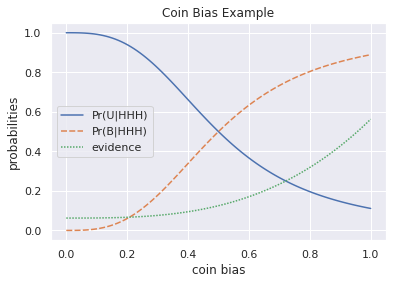

In [17]:
test_res = pd.DataFrame({'Pr(U|HHH)': posterior_U, 
                              'Pr(B|HHH)': posterior_B,
                              'evidence': evidences}, index=biases)
sns.lineplot(data=test_res).set(xlabel='coin bias',
                                     ylabel='probabilities',
                                     title='Coin Bias Example')
plt.show()

## Example 12 - Can we predict eye color from hair color?
Here we load aggregate data (of numbers of people with certain eye/hair color combinations)

In [18]:
! git clone https://github.com/manishbayesian/bayesianbookpub.git

Cloning into 'bayesianbookpub'...
remote: Enumerating objects: 16, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 16 (delta 4), reused 7 (delta 1), pack-reused 0
Unpacking objects: 100% (16/16), done.


In [22]:
eyes_hair_agg = pd.read_csv('bayesianbookpub/datasets/eye_hair_colors_aggregated.csv',index_col='Eye Color')
eyes_hair_agg

,Light Hair,Dark Hair
Eye Color,,
Green,144,181
Hazel,114,366
Blue,549,556
Brown,159,941
Other,2,9


###### First we create a helper function, that allows us to create a BayesCalculator from aggregate data
###### Without any data, the probability of a person having blue and brown eyes is roughly the same (about 36%)

In [23]:

def bayes_calc_from_aggregate_data(agg_df):
    hypotheses = list(agg_df.index)
    priors = agg_df.sum(axis=1).values
    bcal = BayesCalculator(hypotheses,priors)
    for c in agg_df.columns:
      bcal.set_likelihood(c, (agg_df[c]/agg_df.sum(axis=1).values))
    return bcal

In [24]:
# We create an instance of a BayesCalculator from this aggregate data
eyes = bayes_calc_from_aggregate_data(eyes_hair_agg)

In [25]:
# Display probability of a person having different eye colors
display(eyes.as_table()[['prior']])

,prior
Green,0.108
Hazel,0.159
Blue,0.366
Brown,0.364
Other,0.004


###### Now if we are given information that the person has Dark Hair. Then we can use our `BayesCalculator` to perform an update with this data and see how the probability of having different eye colors changes.

In [26]:
## Update with data = 'Dark Hair' and then examine probabilities.
eyes = eyes.update('Dark Hair')
display(eyes.as_table())

,prior,likelihood,evidence,posterior
Green,0.108,0.557,0.680,0.088
Hazel,0.159,0.762,0.680,0.178
Blue,0.366,0.503,0.680,0.271
Brown,0.364,0.855,0.680,0.458
Other,0.004,0.818,0.680,0.004


###### We notice that now brown eyes are more likely than blue eyes once we have information that the person has dark hair. This can also be visualized as shown below

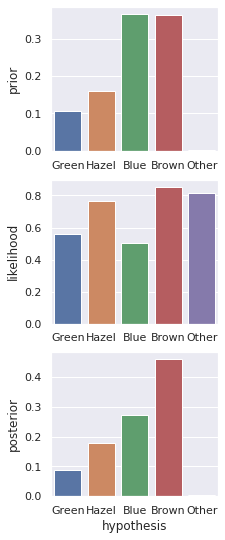

In [28]:
hyp = eyes.as_table().index
dat = eyes.as_table()
f, ax = plt.subplots(3,1,figsize=(3,9),)
sns.barplot(y='prior',     x=hyp,data=dat,ax=ax[0])
sns.barplot(y='likelihood',x=hyp,data=dat,ax=ax[1])
sns.barplot(y='posterior', x=hyp,data=dat,ax=ax[2]).set(xlabel='hypothesis')
plt.show()


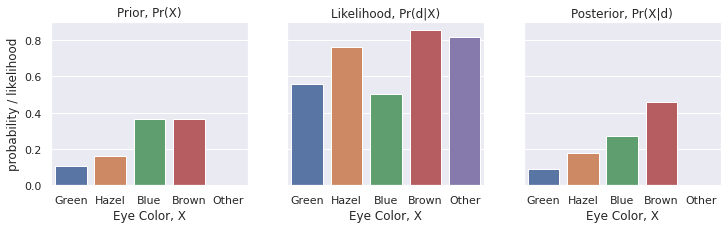

In [38]:
## for generating figure only, remove fro notebook
hyp = eyes.as_table().index
dat = eyes.as_table()
f, ax = plt.subplots(1,3,figsize=(12,3),sharey=True)
sns.barplot(y='prior',     x=hyp,data=dat,ax=ax[0]).set(xlabel='Eye Color, X', title='Prior, Pr(X)', ylabel='probability / likelihood')
sns.barplot(y='likelihood',x=hyp,data=dat,ax=ax[1]).set(xlabel='Eye Color, X', title='Likelihood, Pr(d|X)', ylabel=None)
sns.barplot(y='posterior', x=hyp,data=dat,ax=ax[2]).set(xlabel='Eye Color, X', title='Posterior, Pr(X|d)', ylabel=None)
plt.show()

## Example 13: Medical Tests - How well can a Covid test predict that you are actually infected ?

In [39]:
## Covid Example.
# Use figures from https://pubmed.ncbi.nlm.nih.gov/34242764/
# Sensitivity of the rapid antigen test was 65.3% and the specificity was 99.9% 
## Here let's use fictitious numbers of specificity=97.5, sensitivity=94.3

covid_test = BayesCalculator(['not infected','infected'],prior=[0.95,0.05])

## Likelihoods (for -ve test) are specifity, 1- sensitivity
## Likelihoods (for +ve test) are 1-specificity, sensitivity
covid_test = covid_test \
            .set_likelihood('Negative',[97.5,5.7]) \
            .set_likelihood('Positive',[2.5, 94.3])

In [40]:
covid_test = covid_test.update('Positive')
display(covid_test.as_table())

,prior,likelihood,evidence,posterior
not infected,0.950,2.500,7.090,0.335
infected,0.050,94.300,7.090,0.665


### testing

In [41]:
sensitivity = 0.943
specificity = 0.957
prevalence = np.linspace(0,1.,100)
infected_prob_pos = []
infected_prob_neg = []
for p in prevalence:
  test = BayesCalculator(['NI','I'],prior=[1-p,p]) \
          .set_likelihood('-',[specificity,    1.-sensitivity]) \
          .set_likelihood('+',[1.-specificity, sensitivity])
  test = test.update('+')
  infected_prob_pos.append(test.update('+').posterior()['I'])
  infected_prob_neg.append(test.update('-').posterior()['I'])


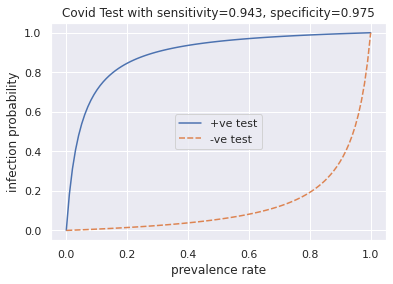

In [42]:
infected_prob = pd.DataFrame({'+ve test':infected_prob_pos, '-ve test':infected_prob_neg},index=prevalence)
sns.lineplot(data=infected_prob).set(xlabel='prevalence rate',
                                     ylabel='infection probability',
                                     title='Covid Test with sensitivity=0.943, specificity=0.975')
plt.show()

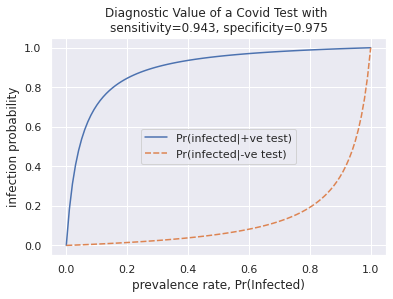

In [46]:
### For Figure only
infected_prob = pd.DataFrame({'Pr(infected|+ve test)':infected_prob_pos, 
                              'Pr(infected|-ve test)':infected_prob_neg},index=prevalence)
sns.lineplot(data=infected_prob).set(xlabel='prevalence rate, Pr(Infected)',
                                     ylabel='infection probability',
                                     title='Diagnostic Value of a Covid Test with \nsensitivity=0.943, specificity=0.975')
plt.show()

In [48]:
ss_values = np.linspace(0,1.,100)
covid_rate_sens = []
ss = np.linspace(0,1.,100)
covid_rate_sens = []
covid_rate_spec = []

for s in ss_values:
  specificity = 0.95
  sensitivity = s
  test = BayesCalculator(['NI','I'],prior=[0.95,0.05]) \
          .set_likelihood('-',[specificity,    1.-sensitivity]) \
          .set_likelihood('+',[1.-specificity, sensitivity])
  covid_rate_sens.append(test.update('+').posterior()['I'])

for s in ss_values:
  specificity = s
  sensitivity = 0.95
  test = BayesCalculator(['NI','I'],prior=[0.95,0.05]) \
          .set_likelihood('-',[specificity,    1.-sensitivity]) \
          .set_likelihood('+',[1.-specificity, sensitivity])
  covid_rate_spec.append(test.update('+').posterior()['I'])

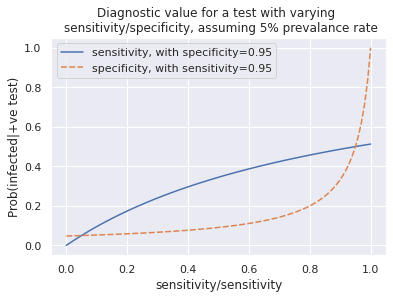

In [49]:
infected_prob = pd.DataFrame({'sensitivity, with specificity=0.95':covid_rate_sens, 
                              'specificity, with sensitivity=0.95':covid_rate_spec},
                              index=ss_values)
sns.lineplot(data=infected_prob).set(xlabel='sensitivity/sensitivity',
                                     ylabel='Prob(infected|+ve test)',
                                     title='Diagnostic value for a test with varying \n sensitivity/specificity, assuming 5% prevalance rate')
plt.show()

## Chapter 1. Example 15
Monty Hall problem.

## Chapter 1. Example 19, Naive Bayes
Here we load the sklearn Iris dataset, and discretize it. 
Then we use our `RecursiveBayesCalculator` to perfom classificaiton.

In [1]:
from sklearn.datasets import load_iris
irisdat = load_iris(as_frame=True)

In [30]:
## examine few rows
display(irisdat['data'].head(5))

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.100,3.500,1.400,0.200
1,4.900,3.000,1.400,0.200
2,4.700,3.200,1.300,0.200
3,4.600,3.100,1.500,0.200
4,5.000,3.600,1.400,0.200


In [3]:
from sklearn.preprocessing import LabelEncoder
featenc = LabelEncoder()

In [4]:
def convert_to_categorical(datadf, featname, ncats=5):
  return featenc.fit_transform(pd.cut(datadf[featname], ncats, retbins=True)[0])

In [5]:
iris_df = pd.DataFrame({
    'sepal_len' : convert_to_categorical(irisdat['data'], 'sepal length (cm)', 8),
    'sepal_wth' : convert_to_categorical(irisdat['data'], 'sepal width (cm)',  4),
    'petal_len' : convert_to_categorical(irisdat['data'], 'petal length (cm)', 6),
    'petal_wth' : convert_to_categorical(irisdat['data'], 'petal width (cm)',  2),
  #  'species'   : list(map(lambda y:irisdat['target_names'][y],irisdat['target']))
})

In [28]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(iris_df, irisdat.target, random_state=0)
X_train_2 = irisdat['data'].loc[X_train.index]
X_test_2 = irisdat['data'].loc[X_test.index]

In [20]:
irisdat['data'].loc[X_train.index]

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
61,5.900,3.000,4.200,1.500
92,5.800,2.600,4.000,1.200
112,6.800,3.000,5.500,2.100
2,4.700,3.200,1.300,0.200
141,6.900,3.100,5.100,2.300
...,...,...,...,...
9,4.900,3.100,1.500,0.100
103,6.300,2.900,5.600,1.800
67,5.800,2.700,4.100,1.000
117,7.700,3.800,6.700,2.200


In [29]:
from sklearn.naive_bayes import MultinomialNB
model_1 = MultinomialNB().fit(X_train, y_train)
from sklearn.naive_bayes import GaussianNB
model_2 = GaussianNB(var_smoothing=2e-9).fit(X_train_2, y_train)
model_2 = GaussianNB().fit(X_train_2, y_train)

In [30]:
y_pred_1 = model_1.predict(X_test)
y_pred_2 = model_2.predict(X_test_2)

In [13]:
from sklearn.metrics import confusion_matrix

mat = confusion_matrix(y_test, y_pred)

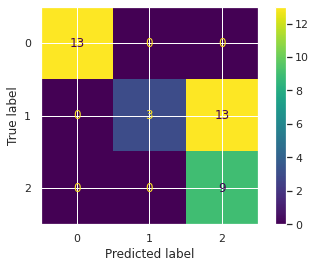

In [16]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

In [31]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_1, target_names=irisdat.target_names))
print(classification_report(y_test, y_pred_2, target_names=irisdat.target_names))

              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        13
  versicolor       1.00      0.19      0.32        16
   virginica       0.41      1.00      0.58         9

    accuracy                           0.66        38
   macro avg       0.80      0.73      0.63        38
weighted avg       0.86      0.66      0.61        38

              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        13
  versicolor       1.00      1.00      1.00        16
   virginica       1.00      1.00      1.00         9

    accuracy                           1.00        38
   macro avg       1.00      1.00      1.00        38
weighted avg       1.00      1.00      1.00        38



In [43]:
display(iris_df.head())

,sepal_len,sepal_wth,petal_len,petal_wth,species
0,1,2,0,0,setosa
1,1,1,0,0,setosa
2,0,1,0,0,setosa
3,0,1,0,0,setosa
4,1,2,0,0,setosa


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2
...,...,...,...,...
145,6.7,3.0,5.2,2.3
146,6.3,2.5,5.0,1.9
147,6.5,3.0,5.2,2.0
148,6.2,3.4,5.4,2.3


['setosa',
 'setosa',
 'setosa',
 'setosa',
 'setosa',
 'setosa',
 'setosa',
 'setosa',
 'setosa',
 'setosa',
 'setosa',
 'setosa',
 'setosa',
 'setosa',
 'setosa',
 'setosa',
 'setosa',
 'setosa',
 'setosa',
 'setosa',
 'setosa',
 'setosa',
 'setosa',
 'setosa',
 'setosa',
 'setosa',
 'setosa',
 'setosa',
 'setosa',
 'setosa',
 'setosa',
 'setosa',
 'setosa',
 'setosa',
 'setosa',
 'setosa',
 'setosa',
 'setosa',
 'setosa',
 'setosa',
 'setosa',
 'setosa',
 'setosa',
 'setosa',
 'setosa',
 'setosa',
 'setosa',
 'setosa',
 'setosa',
 'setosa',
 'versicolor',
 'versicolor',
 'versicolor',
 'versicolor',
 'versicolor',
 'versicolor',
 'versicolor',
 'versicolor',
 'versicolor',
 'versicolor',
 'versicolor',
 'versicolor',
 'versicolor',
 'versicolor',
 'versicolor',
 'versicolor',
 'versicolor',
 'versicolor',
 'versicolor',
 'versicolor',
 'versicolor',
 'versicolor',
 'versicolor',
 'versicolor',
 'versicolor',
 'versicolor',
 'versicolor',
 'versicolor',
 'versicolor',
 'versicolor',


In [34]:
data['target_names'][0]

'setosa'

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f88a9456510>,
      dtype=object)

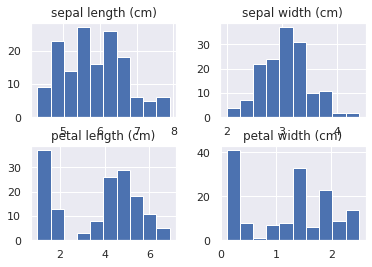

In [21]:
import seaborn as sns
data['data'].hist()

In [26]:
featenc.fit_transform(pd.cut(data['data']['sepal length (cm)'], 5, retbins=True)[0])

array([1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 2, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 1, 0, 1, 0, 3, 2, 3, 1, 3, 1, 2, 0, 3, 1, 0, 2, 2, 2, 1, 3,
       1, 2, 2, 1, 2, 2, 2, 2, 2, 3, 3, 3, 2, 1, 1, 1, 2, 2, 1, 2, 3, 2,
       1, 1, 1, 2, 2, 0, 1, 1, 1, 2, 1, 1, 2, 2, 3, 2, 3, 4, 0, 4, 3, 4,
       3, 2, 3, 1, 2, 2, 3, 4, 4, 2, 3, 1, 4, 2, 3, 4, 2, 2, 2, 4, 4, 4,
       2, 2, 2, 4, 2, 2, 2, 3, 3, 3, 2, 3, 3, 3, 2, 3, 2, 2])